In [1]:
import os
import shutil
import random

# Kategoriler ve ilgili dizinler
category_paths = {
    'BIRADS1': r'D:\mamografi-dataset\Kategori1',
    'BIRADS2': r'D:\mamografi-dataset\Kategori2',
    'BIRADS4': r'D:\mamografi-dataset\Kategori4',
    'BIRADS5': r'D:\mamografi-dataset\Kategori5'
}

# Hedef klasör (yeni veri setinin kaydedileceği yer)
output_dir = r'D:\mamografi-dataset\newDataSet'

# Kategoriye göre istenilen hasta sayıları
patient_counts = {
    'Kategori1': 188,
    'Kategori2': 112,
    'Kategori4': 98,
    'Kategori5': 102
}

# Yeni veri seti ana klasörlerini oluştur
os.makedirs(output_dir, exist_ok=True)

# Her kategori için işlem
for category, category_path in category_paths.items():
    print(f"{category} için işlem başlatılıyor...")

    # Kategorideki hasta ID'lerini listele
    patient_ids = os.listdir(category_path)
    
    # İstenilen sayıda hasta seç
    selected_patients = random.sample(patient_ids, patient_counts[category])
    
    # Yeni kategorinin klasörünü oluştur
    category_output_path = os.path.join(output_dir, category)
    os.makedirs(category_output_path, exist_ok=True)
    
    # Seçilen hastaların dosyalarını kopyala
    for patient_id in selected_patients:
        patient_folder = os.path.join(category_path, patient_id)

        # Hasta klasöründe bulunan dosyalar (RCC.dcm ve RMLO.dcm) kopyalanacak
        if os.path.isdir(patient_folder):
            # Yeni hasta klasörünü oluştur
            new_patient_folder = os.path.join(category_output_path, patient_id)
            os.makedirs(new_patient_folder, exist_ok=True)

            for dicom_file in os.listdir(patient_folder):
                if dicom_file.endswith('.dcm'):
                    source_file = os.path.join(patient_folder, dicom_file)
                    destination_file = os.path.join(new_patient_folder, dicom_file)
                    shutil.copy2(source_file, destination_file)

    print(f"{category} için işlem tamamlandı.")

print("Yeni veri seti başarıyla oluşturuldu.")

BIRADS1 için işlem başlatılıyor...


KeyError: 'BIRADS1'

In [1]:
import pandas as pd
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_windowing
import matplotlib.pyplot as plt
from pathlib import Path

dcm_path_list=[]

def get_pixels_with_windowing(dcm_file):
    im = pydicom.dcmread(dcm_file)
    
    try:
        im.decompress('gdcm')
    except:
        pass

    data = im.pixel_array
    data = apply_windowing(data, im)
    
    if im.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    else:
        data = data - np.min(data)
        
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

def dosyalari_tara(klasor_yolu):
    klasor = Path(klasor_yolu)
    # Yalnızca belirtilen kategorilerdeki dosyaları tarayın
    allowed_categories = ['Kategori1', 'Kategori2', 'Kategori4', 'Kategori5']
    
    # Kategori klasörlerinde '.dcm' dosyalarını ara
    for kategori in allowed_categories:
        kategori_klasor = klasor / kategori  # Kategori klasör yolunu oluştur
        if kategori_klasor.exists():
            for dosya in kategori_klasor.rglob('*.dcm'):
                if dosya.is_file():
                    dcm_path_list.append(dosya.as_posix())


def find_file_path(row):
    patient_id = str(row["patient_id"])
    file_name = row["file_name"]
    bulunanlar = [eleman for eleman in dcm_path_list if patient_id in eleman and file_name in eleman]
    
    if len(bulunanlar) > 0:
        return bulunanlar[0]
    else:
        print(f"File not found for patient {patient_id} and file {file_name}")
        return None  # Dosya yolu bulunamadığında None döndür


def file_dimension_finder(row):
    if row["file_path"] is None:
        return np.nan, np.nan  # None değeri durumunda NaN döndür

    im = pydicom.dcmread(row["file_path"], stop_before_pixels=True)
    height = im.Rows
    width = im.Columns
    return height, width


new_column_names={"KATEGORİ":"category",
                  "HASTA ID":"patient_id",
                  "DOSYA ADI":"file_name",
                  "ETİKET ADI":"ann_class",
                  "ETİKET KOORDİNATLARI":"ann_coordinates"
                 }

df_raw=pd.read_csv("D:/mamografi-dataset/veribilgisi.csv", sep=";")
df_raw=df_raw.rename(columns=new_column_names)
df_raw["category"]=df_raw["category"].str[8:9].astype("int")

df_files = df_raw.groupby(['category', 'patient_id', 'file_name']).size().reset_index().drop(0,axis=1)

klasor_yolu = 'D:/newDataSet'
dosyalari_tara(klasor_yolu)

df_files["file_path"] = df_files.apply(find_file_path, axis=1)

df_files[["raw_height","raw_width"]]=df_files.apply(file_dimension_finder, axis=1,result_type="expand")

df_raw = df_raw.merge(df_files[["patient_id","file_name","file_path", "raw_height","raw_width"]], on=["patient_id","file_name"], how="left")

df_raw["raw_height"] = df_raw["raw_height"].fillna(0).astype(int)
df_raw["raw_width"] = df_raw["raw_width"].fillna(0).astype(int)

coords = df_raw["ann_coordinates"].str.split(";", expand=True)
df_raw[["x1", "y1"]] = coords[0].str.split(",", expand=True).apply(pd.to_numeric, errors='coerce')
df_raw[["x2", "y2"]] = coords[2].str.split(",", expand=True).apply(pd.to_numeric, errors='coerce')
df_raw["x1"] = df_raw["x1"] + df_raw["raw_width"] / 2
df_raw["x2"] = df_raw["x2"] + df_raw["raw_width"] / 2
df_raw["y1"] = df_raw["y1"] + df_raw["raw_height"] / 2
df_raw["y2"] = df_raw["y2"] + df_raw["raw_height"] / 2

File not found for patient 10001 and file RCC.dcm
File not found for patient 10001 and file RMLO.dcm
File not found for patient 10002 and file LCC.dcm
File not found for patient 10002 and file LMLO.dcm
File not found for patient 10003 and file RCC.dcm
File not found for patient 10003 and file RMLO.dcm
File not found for patient 10004 and file LCC.dcm
File not found for patient 10004 and file LMLO.dcm
File not found for patient 10005 and file LCC.dcm
File not found for patient 10005 and file LMLO.dcm
File not found for patient 10006 and file LCC.dcm
File not found for patient 10006 and file LMLO.dcm
File not found for patient 10007 and file LCC.dcm
File not found for patient 10007 and file LMLO.dcm
File not found for patient 10008 and file RCC.dcm
File not found for patient 10008 and file RMLO.dcm
File not found for patient 10009 and file LCC.dcm
File not found for patient 10009 and file LMLO.dcm
File not found for patient 10010 and file RCC.dcm
File not found for patient 10010 and file

In [2]:
len(dcm_path_list)

1000

In [3]:
df_raw[df_raw["patient_id"] == 10013]

,category,patient_id,file_name,ann_class,ann_coordinates,file_path,raw_height,raw_width,x1,y1,x2,y2
24,1,10013,RCC.dcm,Normal,NaN,D:/newDataSet/Kategori1/10013/RCC.dcm,2964,2364,NaN,NaN,NaN,NaN
25,1,10013,RMLO.dcm,Normal,NaN,D:/newDataSet/Kategori1/10013/RMLO.dcm,2964,2364,NaN,NaN,NaN,NaN


In [4]:
def space_between_coordinates(coordinates):
    if isinstance(coordinates, str):
        coordinates = coordinates.strip('[]') 
        dots = [list(map(float, p.split(','))) for p in coordinates.split(';')]
        if len(dots) == 4:
            x1, y1 = dots[0]
            x2, y2 = dots[1]
            x3, y3 = dots[2]
            x4, y4 = dots[3]
            length_y = abs(y2 - y1)  # Dikey mesafe
            length_x = abs(x4 - x1)  # Yatay mesafe
            return length_x * length_y  # Alanı hesapla (uzunluklar çarpılır)
    return None  # Koordinatlar beklenen formatta değilse

# Kare alanlarını dataframe'e ekle
df_raw['space_between_coordinates'] = df_raw['ann_coordinates'].apply(space_between_coordinates)

In [5]:
df_raw

,category,patient_id,file_name,ann_class,ann_coordinates,file_path,raw_height,raw_width,x1,y1,x2,y2,space_between_coordinates
0,1,10001,RCC.dcm,Normal,NaN,None,0,0,NaN,NaN,NaN,NaN,NaN
1,1,10001,RMLO.dcm,Normal,NaN,None,0,0,NaN,NaN,NaN,NaN,NaN
2,1,10002,LCC.dcm,Normal,NaN,None,0,0,NaN,NaN,NaN,NaN,NaN
3,1,10002,LMLO.dcm,Normal,NaN,None,0,0,NaN,NaN,NaN,NaN,NaN
4,1,10003,RCC.dcm,Normal,NaN,None,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,5,12719,LMLO.dcm,Kitle,"-693.9316,-327.6231;-693.9316,-134.1276;-531.2...",D:/newDataSet/Kategori5/12719/LMLO.dcm,2964,2364,488.0684,1154.3769,650.78050,1347.87240,31484.059146
7010,5,12720,LCC.dcm,Kitle,"-727.322,-419.7589;-727.322,-50.79141;-379.371...",None,0,0,-727.3220,-419.7589,-379.37160,-50.79141,128382.385732
7011,5,12720,LMLO.dcm,Kitle,"-595.595,-382.3951;-595.595,-64.80284;-289.678...",None,0,0,-595.5950,-382.3951,-289.67890,-64.80284,97156.585569
7012,5,12721,LCC.dcm,Kitle,"-524.7009,-961.3434;-524.7009,-541.2303;-65.25...",None,0,0,-524.7009,-961.3434,-65.25144,-541.23030,193020.736934


In [6]:
# import pandas as pd

# file_path sütununda None (veya NaN) olan satırları sil
df_cleaned = df_raw.dropna(subset=['file_path'])

In [7]:
df_cleaned

,category,patient_id,file_name,ann_class,ann_coordinates,file_path,raw_height,raw_width,x1,y1,x2,y2,space_between_coordinates
24,1,10013,RCC.dcm,Normal,NaN,D:/newDataSet/Kategori1/10013/RCC.dcm,2964,2364,NaN,NaN,NaN,NaN,NaN
25,1,10013,RMLO.dcm,Normal,NaN,D:/newDataSet/Kategori1/10013/RMLO.dcm,2964,2364,NaN,NaN,NaN,NaN,NaN
36,1,10019,RCC.dcm,Normal,NaN,D:/newDataSet/Kategori1/10019/RCC.dcm,2964,2364,NaN,NaN,NaN,NaN,NaN
37,1,10019,RMLO.dcm,Normal,NaN,D:/newDataSet/Kategori1/10019/RMLO.dcm,2964,2364,NaN,NaN,NaN,NaN,NaN
40,1,10021,LCC.dcm,Normal,NaN,D:/newDataSet/Kategori1/10021/LCC.dcm,2964,2364,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6964,5,12703,LCC.dcm,Kalsifikasyon,"-637.4208,157.9862;-637.4208,352.4736;-499.887...",D:/newDataSet/Kategori5/12703/LCC.dcm,2964,2364,544.5792,1639.9862,682.1125,1834.4736,26748.493930
6965,5,12703,LMLO.dcm,Kitle,"-794.5806,462.2489;-794.5806,661.3762;-597.885...",D:/newDataSet/Kategori5/12703/LMLO.dcm,2964,2364,387.4194,1944.2489,584.1149,2143.3762,39167.443837
6966,5,12703,LMLO.dcm,Kalsifikasyon,"-828.6984,474.3636;-828.6984,642.5131;-637.154...",D:/newDataSet/Kategori5/12703/LMLO.dcm,2964,2364,353.3016,1956.3636,544.8458,2124.5131,32208.061458
7008,5,12719,LCC.dcm,Kitle,"-964.3199,-491.4699;-964.3199,-335.8694;-785.9...",D:/newDataSet/Kategori5/12719/LCC.dcm,2964,2364,217.6801,990.5301,396.0514,1146.1306,27754.663466


In [8]:
len(df_cleaned)

1284

In [9]:
unique_patient_id = df_cleaned['patient_id'].nunique()
print(unique_patient_id)

500


In [1]:
#SAM MODELİ

In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q roboflow supervision
!curl -O -k https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Active code page: 1252
  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\havva\appdata\local\temp\pip-req-build-eb4l2379
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\havva\AppData\Local\Temp\pip-req-build-eb4l2379'


Active code page: 1252


Active code page: 1252


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 2445M    0 1744k    0     0  1673k      0  0:24:56  0:00:01  0:24:55 1677k
  0 2445M    0 14.8M    0     0  7469k      0  0:05:35  0:00:02  0:05:33 7478k
  1 2445M    1 27.1M    0     0  9145k      0  0:04:33  0:00:03  0:04:30 9150k
  1 2445M    1 40.0M    0     0  9837k      0  0:04:14  0:00:04  0:04:10 9841k
  2 2445M    2 53.4M    0     0  10.5M      0  0:03:50  0:00:05  0:03:45 10.6M
  2 2445M    2 66.6M    0     0  11.0M      0  0:03:41  0:00:06  0:03:35 12.9M
  3 2445M    3 79.6M    0     0  11.3M      0  0:03:36  0:00:07  0:03:29 12.9M
  3 2445M    3 92.8M    0     0  11.5M      0  0:03:31  0:00:08  0:03:23 13.1M
  4 2445M    4  105M    0     0  11.6M      0  0:03

In [3]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Modeli yükle (Hafif model: vit_b, Orta model: vit_l, En güç- vit_h)
sam_checkpoint = "D:\mamografi-dataset\sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

# SAM modelini çağır
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)

C:\Users\havva\AppData\Local\Programs\Python\Python310\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [4]:
# Otomatik mask oluşturucu
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_batch=16,   # Daha az nokta işleyerek bellek tasarrufu
    min_mask_region_area=100000  # Küçük maskeleri yok sayar, RAM kullanımını düşürür
)

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image

def detect_mask(image_type, masks, width, height):
    if image_type == 'RCC':
        x = width - 20
        y = height // 2
    elif image_type == 'LCC':
        x = 20
        y = height // 2
    elif image_type == 'RMLO':
        x = width * 5 // 6
        y = height // 2
    elif image_type == 'LMLO':
        x = width // 6
        y = height // 2
    else:
        return None, None

    for index, mask_dict in enumerate(masks):
        mask = mask_dict['segmentation']
        if mask.shape[0] > y and mask.shape[1] > x:
            if mask[y, x]:
                return mask, index

    return None, None

def process_images(input_dir, output_dir, mask_generator):
    os.makedirs(output_dir, exist_ok=True)
    
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category, f"{category}_converted")
        category_output_path = os.path.join(output_dir, f"{category}_cropped")
        os.makedirs(category_output_path, exist_ok=True)
        
        if not os.path.isdir(category_path):
            continue
        
        for image_file in os.listdir(category_path):
            if not image_file.endswith(".png"):
                continue
            
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            masks = mask_generator.generate(image)
            torch.cuda.empty_cache()
            
            if not masks:
                print(f"Maske bulunamadı: {image_file}")
                continue
            
            image_type = image_file.split('_')[-1].split('.')[0]
            mask, index = detect_mask(image_type, masks, image.shape[1], image.shape[0])
            
            if mask is None:
                print(f"Uygun maske bulunamadı: {image_file}")
                continue
            
            coordinates = masks[index]['bbox']
            
            left = int(coordinates[0])
            top = int(coordinates[1])
            right = int(left + coordinates[2])
            bottom = int(top + coordinates[3])
            
            cropped_image = image[top:bottom, left:right]
            cropped_image_pil = Image.fromarray(cropped_image)
            
            target_size = (512, 512)
            cropped_image_pil.thumbnail((512, 512), Image.LANCZOS)
            new_image = Image.new("L", target_size, 0)
            
            if image_type in ['LCC', 'LMLO']:
                x_offset = 0  # Sağ taraf doldurulacak
            else:
                x_offset = target_size[0] - cropped_image_pil.width  # Sol taraf doldurulacak
            
            y_offset = (target_size[1] - cropped_image_pil.height) // 2
            new_image.paste(cropped_image_pil, (x_offset, y_offset))
            
            output_path = os.path.join(category_output_path, image_file)
            new_image.save(output_path)
            print(f"Kaydedildi: {output_path}")

if __name__ == "__main__":
    input_dir = r"D://newDataSet"
    output_dir = r"D://croppedDataSet"
    process_images(input_dir, output_dir, mask_generator)

Kaydedildi: D://croppedDataSet\Kategori0_cropped\10809_LCC.png
Kaydedildi: D://croppedDataSet\Kategori0_cropped\10809_LMLO.png


In [5]:
# Görüntüyü yükle
image = cv2.imread("D:/mamografi-output/converted_images/10809_LCC.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Maskeleri üret
masks = mask_generator.generate(image)

# Belleği temizle
import gc
gc.collect()
torch.cuda.empty_cache()

# Kaç tane maske üretildiğini kontrol et
print(f"Toplam {len(masks)} maske üretildi.")

# Maskelerin ilk 5 tanesinin alanlarını ve skorlarını yazdır
for i, mask in enumerate(masks[:5]):
    print(f"Maske {i}: Alan={mask['area']}, Skor={mask['predicted_iou']:.2f}")

Toplam 9 maske üretildi.
Maske 0: Alan=2875915, Skor=1.03
Maske 1: Alan=318479, Skor=1.00
Maske 2: Alan=1236975, Skor=1.00
Maske 3: Alan=105107, Skor=0.96
Maske 4: Alan=41437, Skor=1.01


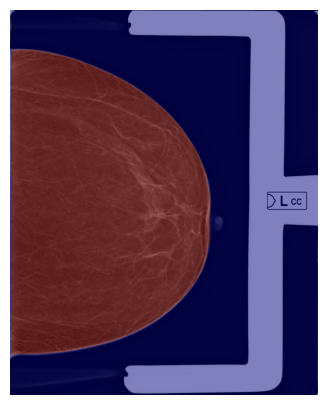

In [6]:
# Görüntüyü ve maskeleri görselleştir
plt.figure(figsize=(10, 5))

# Görüntüyü ekle
plt.imshow(image)
plt.axis('off')

# Maskeyi ekle
if len(masks) > 0:
    # İlk maskeyi al
    mask = masks[0]['segmentation']  # Maskenin segmentasyonunu al
    plt.imshow(mask, alpha=0.5, cmap='jet')  # Maskeyi üzerine ekle
plt.axis('off')
plt.show()

In [7]:
coordinates = masks[0]['bbox']
area = masks[0]['area']

In [8]:
coordinates

[9.0, 302.0, 1526.0, 2349.0]

In [9]:
area

2875915

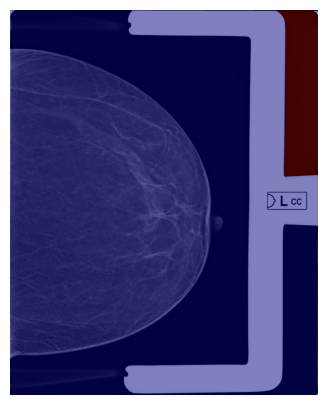

In [10]:
# Görüntüyü ve maskeleri görselleştir
plt.figure(figsize=(10, 5))

# Görüntüyü ekle
plt.imshow(image)
plt.axis('off')

# Maskeyi ekle
if len(masks) > 0:
    # İlk maskeyi al
    mask = masks[1]['segmentation']  # Maskenin segmentasyonunu al
    plt.imshow(mask, alpha=0.5, cmap='jet')  # Maskeyi üzerine ekle
plt.axis('off')
plt.show()

In [11]:
coordinates = masks[1]['bbox']
area = masks[1]['area']

coordinates

[2052.0, 0.0, 309.0, 1276.0]

In [17]:
area

2052712

In [18]:
segmentation = masks[1]['segmentation']

In [19]:
segmentation

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(2964, 2364))

In [88]:
import numpy as np
from PIL import Image

image = cv2.imread("D:/mamografi-output/converted_images/10012_RMLO.png")

def find_mask(masks, width, height):
    
    # noktayı belirle
    x = width - 20
    y = height // 2

    # Her maskeyi kontrol et
    for index,mask_dict in enumerate(masks):
        mask = mask_dict['segmentation']  # Boolean numpy array
        if mask.shape[0] > y and mask.shape[1] >= x:  # Koordinatlar maskenin boyutları içinde mi?
            print("x,y koordinatları maske boyutu içinde")
            if mask[y,x]:  # Eğer bu maskede orta piksel varsa
                return mask,index  # Maskeyi döndür

    return None  # Hiçbir maske içermiyorsa None döndür

# Ortadaki pikseli içeren maskeyi bul
mask,index = find_mask(masks, image.shape[1], image.shape[0])

if mask is not None:
    print("maskeyi bulduk!")
    print("maskenin indexi:", index)
else:
    print("maske bulunamadı.")

x,y koordinatları maske boyutu içinde
x,y koordinatları maske boyutu içinde
x,y koordinatları maske boyutu içinde
x,y koordinatları maske boyutu içinde
maskeyi bulduk!
maskenin indexi: 3


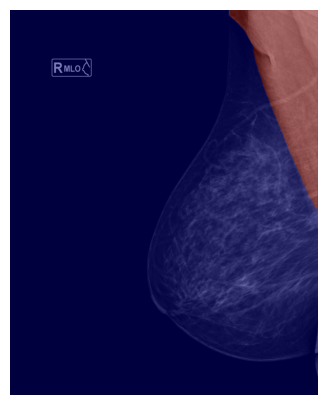

In [89]:
# Görüntüyü ve maskeleri görselleştir
plt.figure(figsize=(10, 5))

# Görüntüyü ekle
plt.imshow(image)
plt.axis('off')

# Maskeyi ekle
if len(masks) > 0:
    # İlk maskeyi al
    mask = masks[3]['segmentation']  # Maskenin segmentasyonunu al
    plt.imshow(mask, alpha=0.5, cmap='jet')  # Maskeyi üzerine ekle
plt.axis('off')
plt.show()

In [66]:
coordinates = masks[index]['bbox']

In [67]:
coordinates

[2102, 7, 706, 2675]

In [68]:
image.shape[1] # genişlik // width

2816

In [69]:
image.shape[0] # yükseklik // height

3584

In [90]:
#RMLO  görüntüler için
import numpy as np
from PIL import Image

image = cv2.imread("D:/mamografi-output/converted_images/10012_RMLO.png")

def find_mask(masks, width, height):
    
    # noktayı belirle
    x = width * 3 // 4
    y = height * 3 // 4

    # Her maskeyi kontrol et
    for index,mask_dict in enumerate(masks):
        mask = mask_dict['segmentation']  # Boolean numpy array
        if mask.shape[0] > y and mask.shape[1] >= x:  # Koordinatlar maskenin boyutları içinde mi?
            print("x,y koordinatları maske boyutu içinde")
            if mask[y,x]:  # Eğer bu maskede orta piksel varsa
                return mask,index  # Maskeyi döndür

    return None  # Hiçbir maske içermiyorsa None döndür

# Ortadaki pikseli içeren maskeyi bul
mask,index = find_mask(masks, image.shape[1], image.shape[0])

if mask is not None:
    print("maskeyi bulduk!")
    print("maskenin indexi:", index)
else:
    print("maske bulunamadı.")

x,y koordinatları maske boyutu içinde
x,y koordinatları maske boyutu içinde
maskeyi bulduk!
maskenin indexi: 1


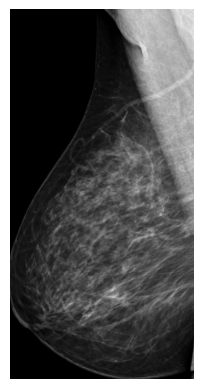

In [91]:
# Kırpma işlemi (sol, üst, sağ, alt)
left = image.shape[1] - coordinates[2]    # X ekseninde başlangıç noktası
top = coordinates[1]  # Y ekseninde başlangıç noktası
width = coordinates[2]  # Kırpılacak genişlik
height = coordinates[3] # Kırpılacak yükseklik

right = left + width
bottom = top + height

cropped_image = image[top:bottom, left:right]

# Kırpılmış görseli göster
plt.imshow(cropped_image)
plt.axis("off")
plt.show()

# Kırpılmış görseli göster
#cropped_image.show()

In [72]:
cropped_image.shape[1]

706

In [73]:
cropped_image.shape[0]

2675

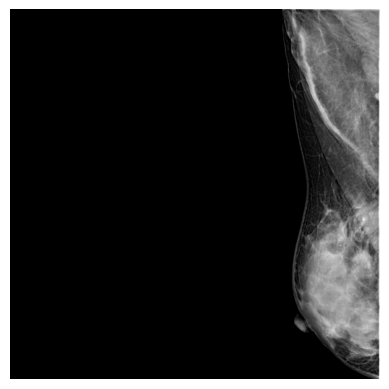

In [75]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Hedef boyut
target_size = (512, 512)

# NumPy dizisini PIL görüntüsüne dönüştürme
cropped_image_pil = Image.fromarray(cropped_image)

# Oranları koruyarak yeniden boyutlandırma
cropped_image_pil.thumbnail((512, 512), Image.LANCZOS)  # Oranı koruyarak küçültme

# Yeni görseli kare yapmak için padding ekleme
new_image = Image.new("L", target_size, 0)  # Gri tonlamalı için 0 (siyah)

# Görselin sol tarafa hizalanması için konum belirleme
x_offset = target_size[0] - cropped_image_pil.width  # Sol taraf boş olacak
y_offset = (target_size[1] - cropped_image_pil.height) // 2  # Dikeyde ortala

# Görseli yeni tuvale yapıştır
new_image.paste(cropped_image_pil, (x_offset, y_offset))

new_image = new_image.convert("RGB")  # RGBA ise RGB'ye çevir
plt.imshow(np.array(new_image))
plt.axis("off")
plt.show()

In [76]:
new_image.height

512

In [77]:
new_image.width

512

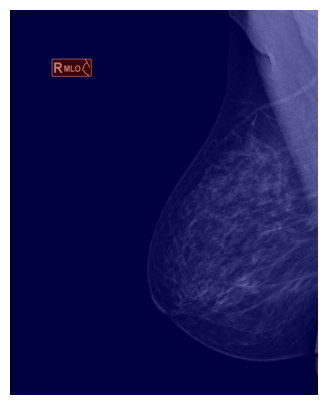

In [30]:
# Görüntüyü ve maskeleri görselleştir
plt.figure(figsize=(10, 5))

# Görüntüyü ekle
plt.imshow(image)
plt.axis('off')

# Maskeyi ekle
if len(masks) > 0:
    # İlk maskeyi al
    mask = masks[2]['segmentation']  # Maskenin segmentasyonunu al
    plt.imshow(mask, alpha=0.5, cmap='jet')  # Maskeyi üzerine ekle
plt.axis('off')
plt.show()

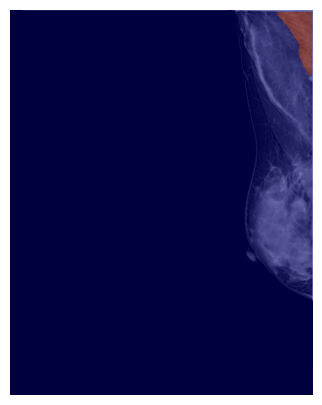

In [78]:
# Görüntüyü ve maskeleri görselleştir
plt.figure(figsize=(10, 5))

# Görüntüyü ekle
plt.imshow(image)
plt.axis('off')

# Maskeyi ekle
if len(masks) > 0:
    # İlk maskeyi al
    mask = masks[3]['segmentation']  # Maskenin segmentasyonunu al
    plt.imshow(mask, alpha=0.5, cmap='jet')  # Maskeyi üzerine ekle
plt.axis('off')
plt.show()

In [3]:
import numpy as np
import pydicom
import cv2
import os

def convert_dicom_to_png(dicom_path, png_path):
    dicom_data = pydicom.dcmread(dicom_path)
    
    phInter = dicom_data.PhotometricInterpretation
    
    img = dicom_data.pixel_array
    
    # MONOCHROME1 için piksel değerlerini tersine çevir
    if phInter == 'MONOCHROME1':
        img = np.max(img) - img  # Piksel değerlerini tersine çevir
        
    # Pencereleme bilgilerini alın
    window_center = dicom_data.WindowCenter
    window_width = dicom_data.WindowWidth
    
     # Pencereleme bilgilerini işleyin
    if isinstance(window_center, pydicom.multival.MultiValue):
        window_center = window_center[0]
    if isinstance(window_width, pydicom.multival.MultiValue):
        window_width = window_width[0]
    
    # Pencere merkezi ve genişliğini kullanarak pencereleme işlemi yapın
    window_center = float(window_center)
    window_width = float(window_width)
    
    # Pikselleri pencereleme
    min_window = window_center - (window_width / 2)
    max_window = window_center + (window_width / 2)
    
    # Normalizasyon ve kesme işlemi
    img = np.clip(img, min_window, max_window)
    img = (img - min_window) / (window_width)

    # Görseli al ve yeniden boyutlandır
    img = np.interp(img, (img.min(), img.max()), (0, 255))  # Normalizasyon
    img = img.astype(np.uint8)  # 8-bit

    cv2.imwrite(png_path, img)

# Ana dizin
input_dir = r'D:\newDataSet\Kategori5'  # DICOM dosyalarının bulunduğu ana dizin
output_dir = r'D:\newDataSet\Kategori5\Kategori5_converted'  # Çıktı dizini

# Çıktı dizinini oluştur
os.makedirs(output_dir, exist_ok=True)

# DICOM dosyalarını dönüştür
for patient_folder in os.listdir(input_dir):
    patient_path = os.path.join(input_dir, patient_folder)
    
    # Hasta klasöründeki dosyaları kontrol et
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith('.dcm'):
                dicom_path = os.path.join(patient_path, file)
                png_filename = f"{patient_folder}_{file.replace('.dcm', '.png')}"  # png dosya adı
                png_path = os.path.join(output_dir, png_filename)
                convert_dicom_to_png(dicom_path, png_path)
                print(f"Dönüştürüldü: {png_path}")

Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12168_RCC.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12168_RMLO.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12169_RCC.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12169_RMLO.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12171_RCC.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12171_RMLO.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12173_RCC.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12173_RMLO.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12174_RCC.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12174_RMLO.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12183_RCC.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12183_RMLO.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\12188_RCC.png
Dönüştürüldü: D:\newDataSet\Kategori5\Kategori5_converted\

Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10013_RCC.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10013_RMLO.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10019_RCC.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10019_RMLO.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10021_LCC.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10021_LMLO.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10023_LCC.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10023_LMLO.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10024_RCC.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10024_RMLO.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10026_RCC.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10026_RMLO.png
Dosya bulunamadı: D:/newDataSet/Kategori2/Kategori2_converted/10027_RCC.png
Dosya 

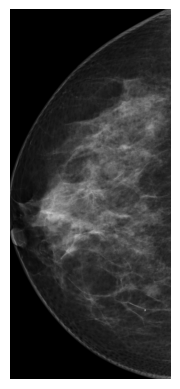

Kırpılmış görsel kaydedildi: D:/newDataSet/Kategori2/Kategori2_cropped/11030_RCC.png


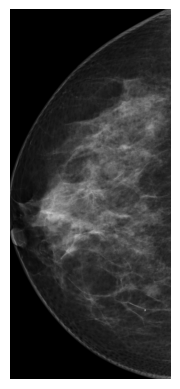

Kırpılmış görsel kaydedildi: D:/newDataSet/Kategori2/Kategori2_cropped/11030_RMLO.png


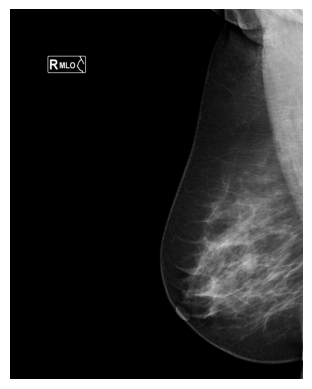

Kırpılmış görsel kaydedildi: D:/newDataSet/Kategori2/Kategori2_cropped/11030_RMLO.png


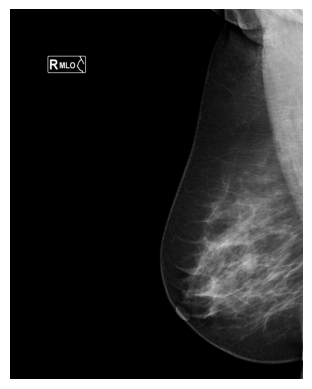

Kırpılmış görsel kaydedildi: D:/newDataSet/Kategori2/Kategori2_cropped/11032_RCC.png


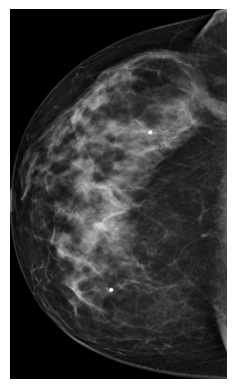

Kırpılmış görsel kaydedildi: D:/newDataSet/Kategori2/Kategori2_cropped/11032_RMLO.png


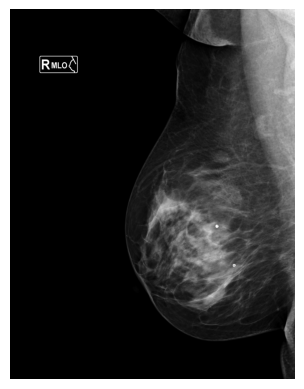

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image
import matplotlib.pyplot as plt

# Otomatik mask oluşturucu
mask_generator = SamAutomaticMaskGenerator(sam)

png_folder = "D:/newDataSet/Kategori2/Kategori2_converted/"
output_folder = "D:/newDataSet/Kategori2/Kategori2_cropped/"
os.makedirs(output_folder, exist_ok=True)

for index, row in df_cleaned.iterrows():
    file_path = row['file_path']  
    patient_id = str(row['patient_id'])
    file_name = row['file_name'].replace(".dcm", ".png")

    # PNG dosyasının tam yolu
    png_path = os.path.join(png_folder, f"{patient_id}_{file_name}")

    if not os.path.exists(png_path):
        print(f"Dosya bulunamadı: {png_path}")
        continue

    #  Görüntüyü yükle ve RGB'ye çevir
    image = cv2.imread(png_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #  Maskeleri oluştur
    masks = mask_generator.generate(image)

    if len(masks) == 0:
        print(f"Maske bulunamadı: {png_path}")
        continue

    #  1.indeksli maskeyi kullan. Genelde ana meme görüntüsü
    mask_index = 1  
    coordinates = masks[mask_index]['bbox']

    # Kırpma işlemi
    left = image.shape[1] - coordinates[2]  # X ekseninde başlangıç noktası
    top = coordinates[1]  # Y ekseninde başlangıç noktası
    width = coordinates[2]  # Kırpılacak genişlik
    height = coordinates[3]  # Kırpılacak yükseklik

    right = left + width
    bottom = top + height

    #  Görüntüyü kırp ve kaydet
    pil_image = Image.fromarray(image)
    cropped_image = pil_image.crop((left, top, right, bottom))
    cropped_image = cropped_image.convert("RGB")

    #  Görseli kaydet
    save_path = os.path.join(output_folder, f"{patient_id}_{file_name}")
    cropped_image.save(save_path)
    print(f"Kırpılmış görsel kaydedildi: {save_path}")

    #  İsterseniz kırpılmış görseli gösterebilirsiniz
    plt.imshow(np.array(cropped_image))
    plt.axis("off")
    plt.show()